# Importar as bibliotecas necessárias

In [1]:
from numpy import asarray
from numpy import zeros
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
import re
from wordcloud import WordCloud, STOPWORDS

import nltk
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping grammars/basque_grammars.zip.
[nltk_data]    | Downloading package bcp47 to /root/nltk_data...
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   U

True

## Carregar os dados

In [2]:
df = pd.read_csv('/content/sentiment_data.csv')
df.head()

,App,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity,date
0,Your App Name,PayPal is an excellent app that works very wel...,Positive,0.228958,0.538333,2023-06-15 10:20:00
1,Your App Name,I like PayPal ok a lot better now than i did w...,Positive,0.126740,0.501648,2023-04-17 22:11:51
2,Your App Name,Customer service was able to help me through a...,Positive,0.262500,0.681481,2023-05-25 18:08:10
3,Your App Name,I really like the convience of the app however...,Positive,0.050000,0.331250,2023-06-14 14:29:33
4,Your App Name,Its trying so hard to be a bank and force opti...,Negative,-0.115741,0.371510,2023-06-05 05:03:38


In [3]:
df.shape

(417588, 6)

## Visualização dos dados

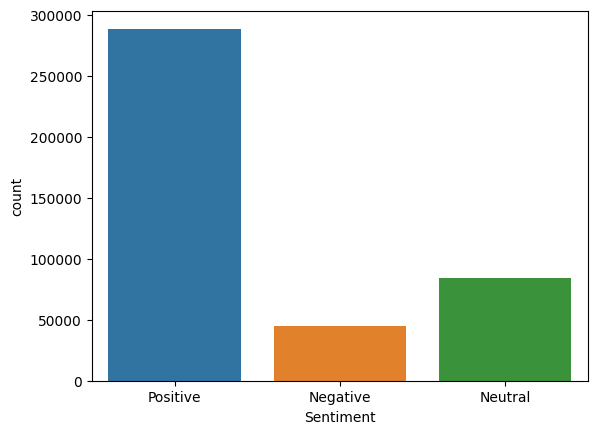

In [4]:
sns.countplot(x='Sentiment', data=df)
plt.show()


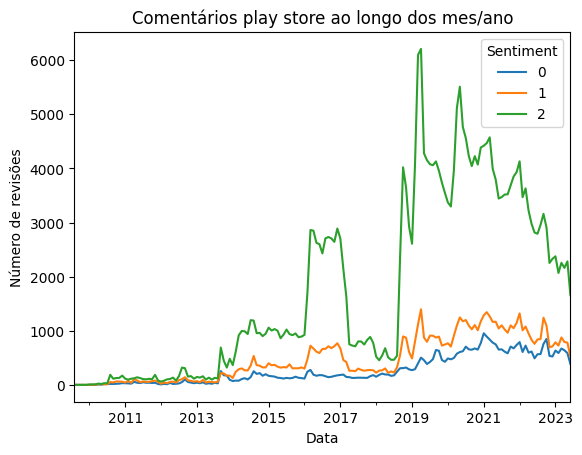

In [58]:
df['date'] = pd.to_datetime(df['date'])

df_grouped = df.groupby([df['date'].dt.to_period('M'), 'Sentiment']).size().unstack()

df_grouped = df_grouped.fillna(0)

df_grouped.plot(kind='line', stacked=False)
plt.title("Comentários play store mes/ano")
plt.xlabel("Data")
plt.ylabel("Número de revisões")
plt.show()

## Remover linhas com valores ausentes

In [6]:
df = df.dropna()

## Preparação dos dados

### Preparação do texto
 - transformar textos em minúsculas
 - obter a contagem de textos únicos
 - lematizar palavras
 - remover palavras irrelevantes - eu tentei, mas os resultados foram piores

In [7]:
lemmatizer = WordNetLemmatizer()
max_words = 0
uniq_words = set()

def clean_text(value):
    global max_words, uniq_words
    val = re.sub('[^a-zA-Z0-9]', ' ', value)

    vals = [lemmatizer.lemmatize(w) for w in word_tokenize(val.lower())]

    if len(vals) > max_words:
        max_words = len(vals)

    uniq_words = uniq_words.union(vals)
    return ' '.join(vals)

In [8]:
df['Translated_Review_tokens'] = df['Translated_Review'].map(clean_text)
num_uniq_words = len(uniq_words)

In [9]:
def remove_caracteres_especiais(texto):
    return re.sub(r'[^\w\s]', '', texto)

In [10]:
def show_word_cloud(text):
    text = remove_caracteres_especiais(text)
    stopwords = set(STOPWORDS)

    wordcloud = WordCloud(
        width = 800,
        height = 800,
        background_color ='white',
        stopwords = stopwords,
        min_font_size = 10
    ).generate(text)

    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.show()

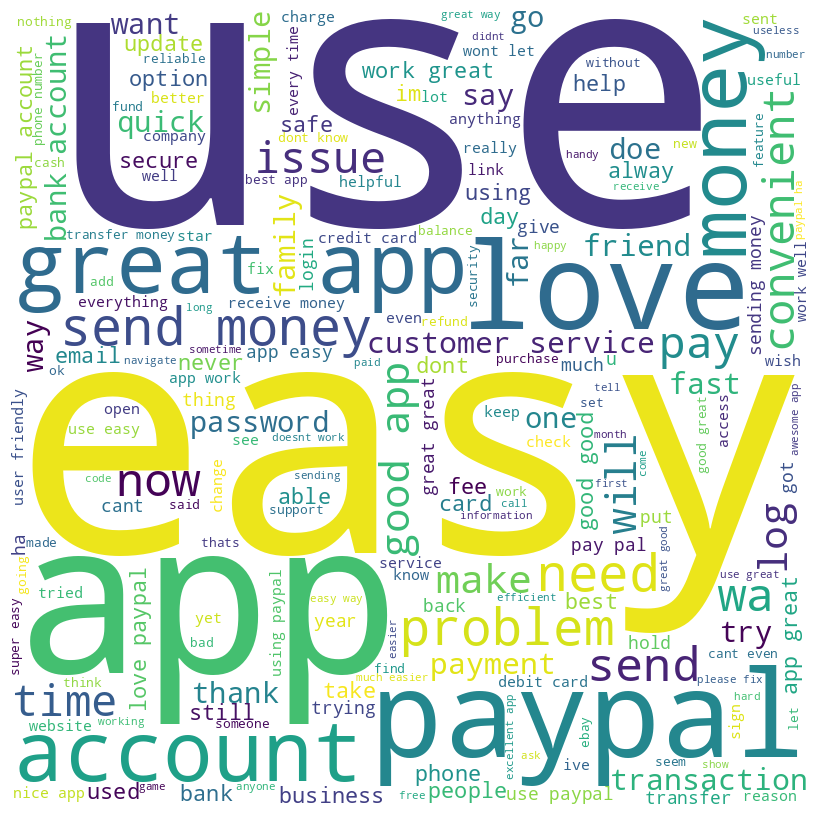

In [11]:
show_word_cloud(df['Translated_Review_tokens'].str.cat(sep=' '))

In [12]:
tokenizer = Tokenizer(num_words=5000, oov_token='OOV')
tokenizer.fit_on_texts(df['Translated_Review_tokens'])
sequences = tokenizer.texts_to_sequences(df['Translated_Review_tokens'])
padded = pad_sequences(sequences)

## Mapeamento dos sentimentos para valores numéricos

In [13]:
sentiment_mapping = {'Positive': 2, 'Neutral': 1, 'Negative': 0}
df['Sentiment'] = df['Sentiment'].map(sentiment_mapping)

## Divisão dos dados em treinamento e teste

In [14]:
#X_train, X_test, y_train, y_test = train_test_split(padded, df['Sentiment'], test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(padded, df['Sentiment'], test_size=0.2, random_state=42)

## Construção da rede LSTM

In [15]:
vocab_length = len(tokenizer.word_index) + 1
embedding_matrix = zeros((vocab_length, 100))
maxlen = max(len(sequence) for sequence in sequences)
print(vocab_length)
print(embedding_matrix)
print(maxlen)

67689
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
630


In [16]:
from keras.layers import Embedding, LSTM, Dense, Dropout, GlobalMaxPooling1D, Conv1D

In [17]:
model_lstm = Sequential()
embedding_layer = Embedding(input_dim=5000, output_dim=16)

model_lstm = Sequential()
model_lstm.add(embedding_layer)
model_lstm.add(LSTM(64, return_sequences=True))
model_lstm.add(LSTM(32))
model_lstm.add(Dense(3, activation='sigmoid'))


### Compilar o modelo

In [18]:
model_lstm.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

###  Treinar a rede

In [19]:
history_lstm = model_lstm.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
10337/10337 [==============================] - 408s 39ms/step - loss: 0.1328 - accuracy: 0.9554 - val_loss: 0.0760 - val_accuracy: 0.9762
Epoch 2/10
10337/10337 [==============================] - 350s 34ms/step - loss: 0.0548 - accuracy: 0.9837 - val_loss: 0.0480 - val_accuracy: 0.9862
Epoch 3/10
10337/10337 [==============================] - 350s 34ms/step - loss: 0.0434 - accuracy: 0.9871 - val_loss: 0.0447 - val_accuracy: 0.9862
Epoch 4/10
10337/10337 [==============================] - 353s 34ms/step - loss: 0.0374 - accuracy: 0.9888 - val_loss: 0.0415 - val_accuracy: 0.9878
Epoch 5/10
10337/10337 [==============================] - 353s 34ms/step - loss: 0.0329 - accuracy: 0.9904 - val_loss: 0.0407 - val_accuracy: 0.9880
Epoch 6/10
10337/10337 [==============================] - 349s 34ms/step - loss: 0.0294 - accuracy: 0.9913 - val_loss: 0.0457 - val_accuracy: 0.9866
Epoch 7/10
10337/10337 [==============================] - 349s 34ms/step - loss: 0.0262 - accuracy: 0.9923

In [20]:
model_lstm.save('model_lstm.h5')

In [21]:
!zip model_lstm.zip model_lstm.h5
from google.colab import files
files.download('model_lstm.zip')


  adding: model_lstm.h5 (deflated 9%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

###  Visualizar o desempenho do modelo

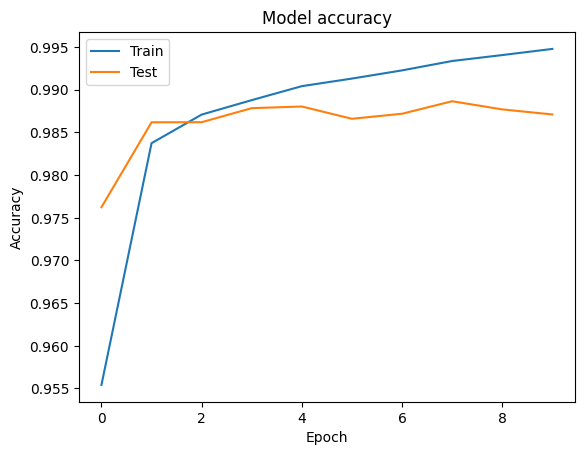

In [22]:
plt.plot(history_lstm.history['accuracy'])
plt.plot(history_lstm.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

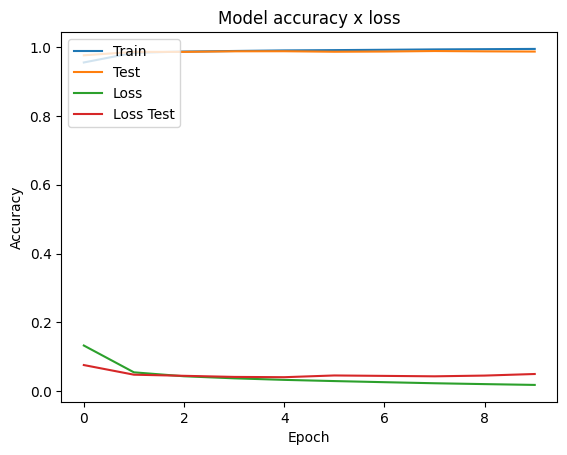

In [23]:
plt.plot(history_lstm.history['accuracy'])
plt.plot(history_lstm.history['val_accuracy'])
plt.plot(history_lstm.history['loss'])
plt.plot(history_lstm.history['val_loss'])
plt.title('Model accuracy x loss')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test', 'Loss', 'Loss Test'], loc='upper left')
plt.show()

### Imprimir a acurácia do modelo no conjunto de treinamento e de teste

In [24]:
train_accuracy = history_lstm.history['accuracy'][-1]
test_accuracy = history_lstm.history['val_accuracy'][-1]

In [25]:
print(f'Acurácia do modelo no conjunto de treinamento: {train_accuracy * 100:.2f}%')
print(f'Acurácia do modelo no conjunto de teste: {test_accuracy * 100:.2f}%')


Acurácia do modelo no conjunto de treinamento: 99.48%
Acurácia do modelo no conjunto de teste: 98.71%


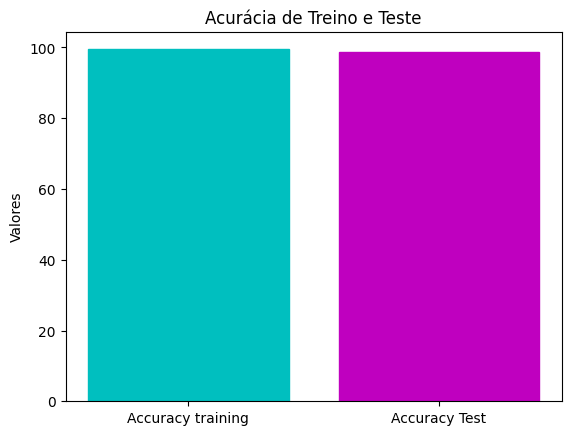

In [26]:
categories = ['Accuracy training', 'Accuracy Test']
values = [train_accuracy * 100, test_accuracy * 100]

# Criação do gráfico
fig, ax = plt.subplots()

# Criação das barras
barlist = ax.bar(categories, values, color='blue')

# Definindo cores diferentes para cada barra
barlist[0].set_color('c')
barlist[1].set_color('m')

# Adicionar rótulos, título e personalizar eixos
ax.set_ylabel('Valores')
ax.set_title('Acurácia de Treino e Teste')
ax.set_xticks(np.arange(len(categories)))
ax.set_xticklabels(categories)

# Exibe o gráfico
plt.show()

### Imprimir a matriz de confusão

In [27]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [60]:
y_pred = model_lstm.predict(X_test)

2585/2585 [==============================] - 35s 14ms/step


In [61]:
model_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          80000     
                                                                 
 lstm (LSTM)                 (None, None, 64)          20736     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 3)                 99        
                                                                 
Total params: 113,251
Trainable params: 113,251
Non-trainable params: 0
_________________________________________________________________


In [66]:
cm = confusion_matrix(y_test, y_pred.argmax(axis=-1))
cm

array([[ 8453,   150,   274],
       [   94, 15867,   101],
       [  265,   182, 57307]])

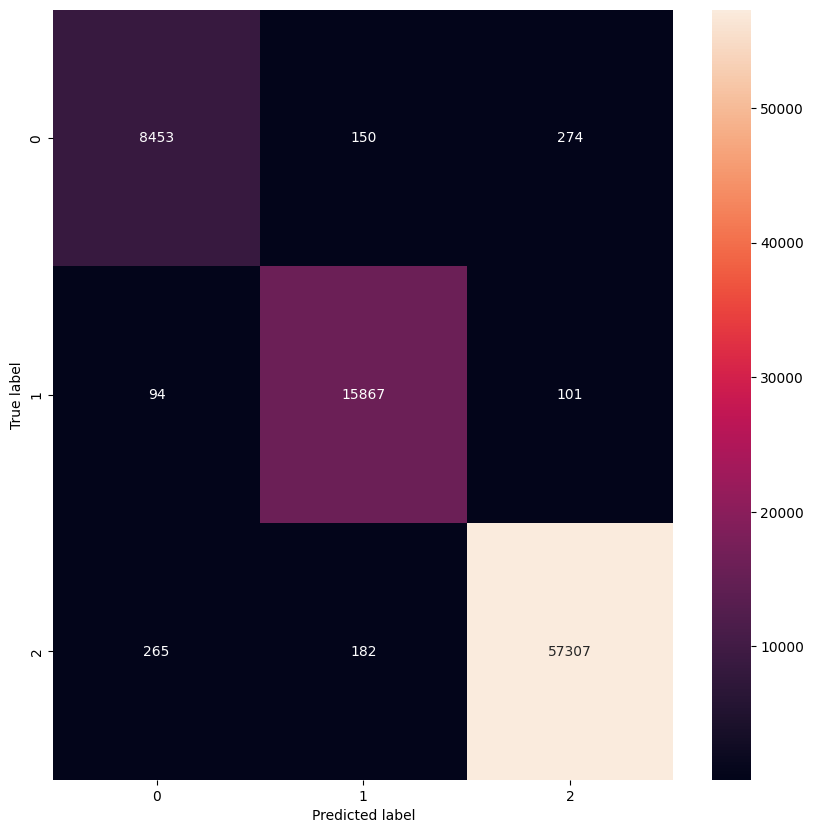

In [67]:
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt='d')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [31]:
new_df = pd.read_csv('/content/googleplaystore_user_reviews.csv')
new_df.head()

,App,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity
0,10 Best Foods for You,I like eat delicious food. That's I'm cooking ...,Positive,1.00,0.533333
1,10 Best Foods for You,This help eating healthy exercise regular basis,Positive,0.25,0.288462
2,10 Best Foods for You,NaN,NaN,NaN,NaN
3,10 Best Foods for You,Works great especially going grocery store,Positive,0.40,0.875000
4,10 Best Foods for You,Best idea us,Positive,1.00,0.300000


### Remover linhas com valores ausentes

In [32]:
new_df = new_df.dropna()

### Preparar os novos dados

In [33]:
new_sequences = tokenizer.texts_to_sequences(new_df['Translated_Review'])
new_padded = pad_sequences(new_sequences)

### Mapear os sentimentos para valores numéricos

In [34]:
new_df['Sentiment'] = new_df['Sentiment'].map(sentiment_mapping)

### Avaliar o modelo nos novos dados

In [35]:
loss, accuracy = model_lstm.evaluate(new_padded, new_df['Sentiment'])

1170/1170 [==============================] - 12s 9ms/step - loss: 0.2723 - accuracy: 0.9334


In [36]:
print(f'Acurácia do modelo nos novos dados: {accuracy * 100:.2f}%')

Acurácia do modelo nos novos dados: 93.34%


In [37]:
print(f'Loss do modelo nos novos dados: {loss:.4f}')

Loss do modelo nos novos dados: 0.2723


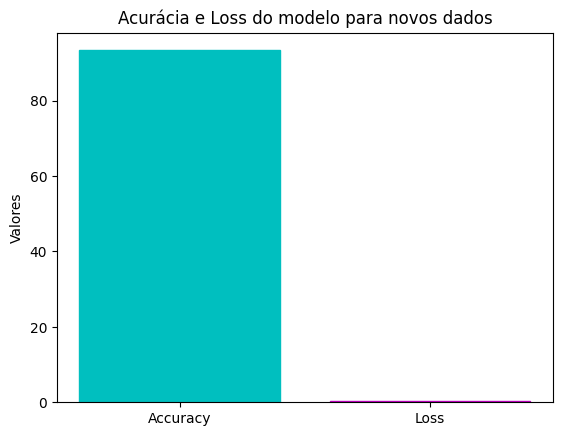

In [38]:
categories = ['Accuracy', 'Loss']
values = [accuracy * 100, loss]

# Criação do gráfico
fig, ax = plt.subplots()

# Criação das barras
barlist = ax.bar(categories, values, color='blue')

# Definindo cores diferentes para cada barra
barlist[0].set_color('c')
barlist[1].set_color('m')

# Adicionar rótulos, título e personalizar eixos
ax.set_ylabel('Valores')
ax.set_title('Acurácia e Loss do modelo para novos dados')
ax.set_xticks(np.arange(len(categories)))
ax.set_xticklabels(categories)

# Exibe o gráfico
plt.show()

In [39]:
# Definir as novas revisões
new_reviews = ['This app is amazing, I love it!',  # Sentimento positivo
               'This app is regular.',  # Sentimento neutro
               'This app is terrible, I hate it!']  # Sentimento negativo

# Preparar os dados
new_reviews_tokenized = tokenizer.texts_to_sequences(new_reviews)
new_reviews_padded = pad_sequences(new_reviews_tokenized, maxlen=X_train.shape[1])

# Fazer previsões
predictions = model_lstm.predict(new_reviews_padded)

# Mapear previsões de volta para sentimentos
sentiment_mapping_inverse = {v: k for k, v in sentiment_mapping.items()}
predicted_sentiments = [sentiment_mapping_inverse[np.argmax(prediction)] for prediction in predictions]

for review, sentiment in zip(new_reviews, predicted_sentiments):
    print(f'Review: {review}\nPredicted sentiment: {sentiment}\n')

1/1 [==============================] - 0s 29ms/step
Review: This app is amazing, I love it!
Predicted sentiment: Positive

Review: This app is regular.
Predicted sentiment: Neutral

Review: This app is terrible, I hate it!
Predicted sentiment: Negative



#Clusterização de sentenças

In [40]:
#Instalando pacotes
!pip install BERTopic
!pip install sentence-transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.4/143.4 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 53.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 11.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 10.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 79.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 79.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 72.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   

In [41]:
from google.colab import files
from zipfile import ZipFile #lib para descompactação

import nltk
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords

from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
from sentence_transformers import SentenceTransformer

In [42]:
df

,App,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity,date,Translated_Review_tokens
0,Your App Name,PayPal is an excellent app that works very wel...,2,0.228958,0.538333,2023-06-15 10:20:00,paypal is an excellent app that work very well...
1,Your App Name,I like PayPal ok a lot better now than i did w...,2,0.126740,0.501648,2023-04-17 22:11:51,i like paypal ok a lot better now than i did w...
2,Your App Name,Customer service was able to help me through a...,2,0.262500,0.681481,2023-05-25 18:08:10,customer service wa able to help me through an...
3,Your App Name,I really like the convience of the app however...,2,0.050000,0.331250,2023-06-14 14:29:33,i really like the convience of the app however...
4,Your App Name,Its trying so hard to be a bank and force opti...,0,-0.115741,0.371510,2023-06-05 05:03:38,it trying so hard to be a bank and force optio...
...,...,...,...,...,...,...,...
417583,Your App Name,K,1,0.000000,0.000000,2016-09-09 05:46:53,k
417584,Your App Name,Yup,1,0.000000,0.000000,2015-08-02 20:34:13,yup
417585,Your App Name,thanks,2,0.200000,0.200000,2016-10-11 14:06:26,thanks
417586,Your App Name,Gewd,1,0.000000,0.000000,2016-04-05 21:39:43,gewd


In [43]:
# Crie uma nova coluna para categorizar os sentimentos
df['Sentiment_Category'] = pd.cut(df['Sentiment_Polarity'],
                                  bins=[-1, -0.01, 0.01, 1],
                                  labels=['Negativo', 'Neutro', 'Positivo'])

In [44]:
positive_df = df[df['Sentiment_Category'] == 'Positivo']
negative_df = df[df['Sentiment_Category'] == 'Negativo']

In [45]:
#transformar a lista de documentos em uma lista de sentenças
sentencas_positivas = [s for review in positive_df['Translated_Review'] for s in sent_tokenize(review)]
sentencas_negativas = [s for review in negative_df['Translated_Review'] for s in sent_tokenize(review)]

In [46]:
print(sentencas_positivas[100])
print(sentencas_negativas[100])

This app is fine the company is not Staying on the phone trying to activate my card for the SECOND time after one of their customer service people made a mistake was not fun but adding several verifications to go through on top of that is just RIDICULOUS Im done with Paypal
This is very very worst onestill now cant able to create accountalways it shows some limitations and suspicious activity on your account like that But actually what is the problem I dont know When I will try to resolve it cant able to upload photo Id costumer care people also not answering properly I am going to uninstall this appsimply this is worst experience and got lots of mental stress due to this app


In [47]:
print(len(sentencas_positivas))
print(len(sentencas_negativas))

287775
41693


In [48]:
#instanciando o modelo
def criar_modelo_bert():
  return BERTopic(language="english", verbose=True, embedding_model="xlm-r-bert-base-nli-stsb-mean-tokens",
                  top_n_words=15, min_topic_size=10, nr_topics=20,
                  vectorizer_model=CountVectorizer(ngram_range=(1,3),
                   stop_words=stopwords.words("english"), min_df=10))
modelo_positivo = criar_modelo_bert()
modelo_negativo = criar_modelo_bert()

In [49]:
#treinar o modelo, %%time para ver o tempo de treinamento
%%time
def treinar_com_bert(sentencas, modelo):
  return modelo.fit_transform(sentencas)
topicos_positivos, probabilidades_positivas = treinar_com_bert(sentencas_positivas, modelo_positivo)
topicos_negativos, probabilidades_negativos = treinar_com_bert(sentencas_positivas, modelo_negativo)

Batches:   0%|          | 0/8993 [00:00<?, ?it/s]

2023-06-25 17:12:24,339 - BERTopic - Transformed documents to Embeddings
2023-06-25 17:35:44,243 - BERTopic - Reduced dimensionality
2023-06-25 17:36:14,622 - BERTopic - Clustered reduced embeddings
2023-06-25 17:36:38,241 - BERTopic - Reduced number of topics from 3011 to 20


Batches:   0%|          | 0/8993 [00:00<?, ?it/s]

2023-06-25 17:41:29,828 - BERTopic - Transformed documents to Embeddings
2023-06-25 18:09:56,869 - BERTopic - Reduced dimensionality
2023-06-25 18:10:25,713 - BERTopic - Clustered reduced embeddings
2023-06-25 18:10:49,229 - BERTopic - Reduced number of topics from 3028 to 20


CPU times: user 4h 33min 18s, sys: 1h 55min 12s, total: 6h 28min 31s
Wall time: 1h 3min 26s


In [50]:
#Tópicos criados pelo modelo
frequencia_positiva = modelo_positivo.get_topic_info()
frequencia_positiva.head(10)

,Topic,Count,Name,Representation,Representative_Docs
0,-1,88648,-1_paypal_account_app_send,"[paypal, account, app, send, use, get, like, d...",[I have a non popular bank that I have fully c...
1,0,180675,0_great_good_love_use,"[great, good, love, use, app, awesome, excelle...",[Great App have very little problems with it e...
2,1,16036,1_account_cant_paypal_get,"[account, cant, paypal, get, would, still, don...",[FINAL UPDATE shutting my PayPal account all t...
3,2,620,2_much_send_good_like,"[much, send, good, like, dont, way, app, great...",[Its great app just charge too much to transfe...
4,3,316,3_new_time_im_using,"[new, time, im, using, need, like, good, ok, s...","[Welcome to the new age, All new to me, New to..."
5,4,285,4_dont_cant_much_new,"[dont, cant, much, new, know, really, right, a...",[Its vert useful Just dont like that I cant se...
6,5,252,5_cant_better_could_need,"[cant, better, could, need, works, would, want...","[cant be better, Cant say better than that, Br..."
7,6,179,6_please_would_able_add,"[please, would, able, add, paypal, option, acc...",[Would love to be able to invoice also from ap...
8,7,138,7_user_ok_good_cant,"[user, ok, good, cant, really, dont, work, thi...","[The UI isnt user friendly, Not user friendly,..."
9,8,121,8_please_option_add_paypal,"[please, option, add, paypal, cant, payments, ...",[Please include RuPay card in the app Nowadays...


In [51]:
#Tópicos criados pelo modelo
frequencia_negativa = modelo_negativo.get_topic_info()
frequencia_negativa.head(10)

,Topic,Count,Name,Representation,Representative_Docs
0,-1,89897,-1_paypal_app_account_send,"[paypal, app, account, send, use, pay, get, ea...",[Im still learning all the sites with in the p...
1,0,182906,0_easy_great_good_love,"[easy, great, good, love, use, app, awesome, e...","[Great app and easy to use, Great app easy to ..."
2,1,11257,1_account_paypal_cant_get,"[account, paypal, cant, get, would, dont, even...",[Twice now Ive relied on PayPal to get money f...
3,2,1112,2_wow_lol_super_ok,"[wow, lol, super, ok, far, much, thing, ever, ...","[wow, wow, Wow]"
4,3,845,3_many_much_dont_like,"[many, much, dont, like, send, good, way, send...",[So many problems in the last year its ridicul...
5,4,363,4_new_time_im_using,"[new, time, im, using, user, far, like, need, ...","[New to it, New, Never 1st time so new experice]"
6,5,295,5_please_would_able_paypal,"[please, would, able, paypal, add, account, av...",[I would like to be able to transfer money fro...
7,6,231,6_lol_user_good_much,"[lol, user, good, much, used, work, dont, cant...","[Lol cant login, noice lol very noice dont rea..."
8,7,178,7_needs_could_better_need,"[needs, could, better, need, would, add, want,...",[Would be better if I could screen shot when I...
9,8,164,8_cant_better_would_dont know,"[cant, better, would, dont know, know, love, g...","[Cant live without it, Cant live without it, c..."


In [52]:
modelo_positivo.visualize_barchart(n_words=5,top_n_topics=10)

In [53]:
modelo_negativo.visualize_barchart(n_words=5,top_n_topics=10)

In [54]:
# Contar os tópicos e pegar os 5 principais
positive_topic_counts = topicos_positivos
negative_topic_counts = topicos_negativos

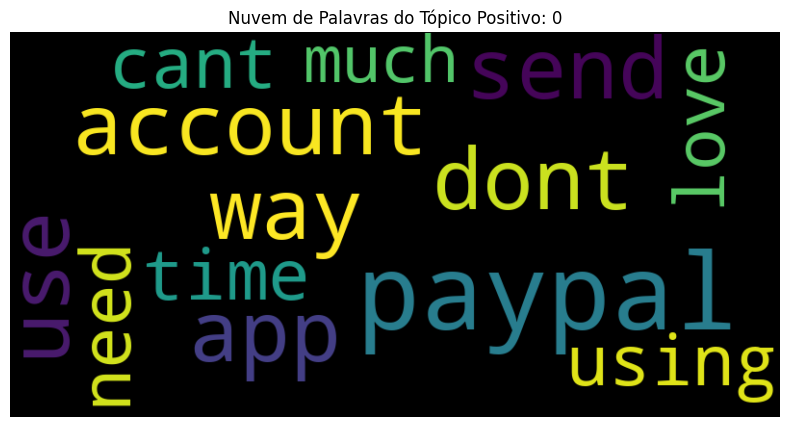

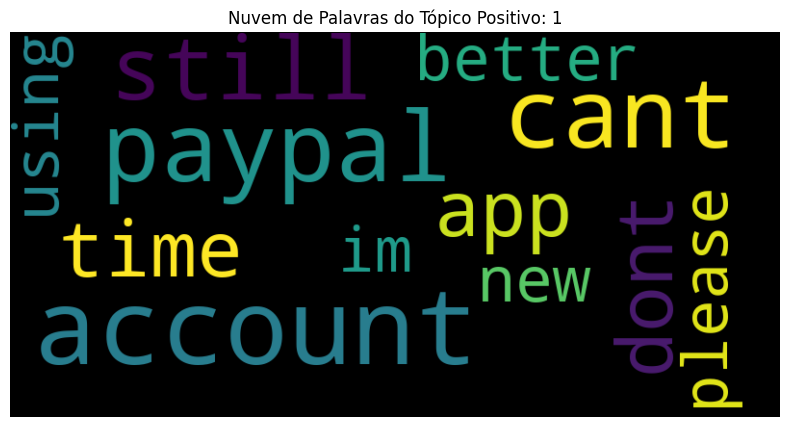

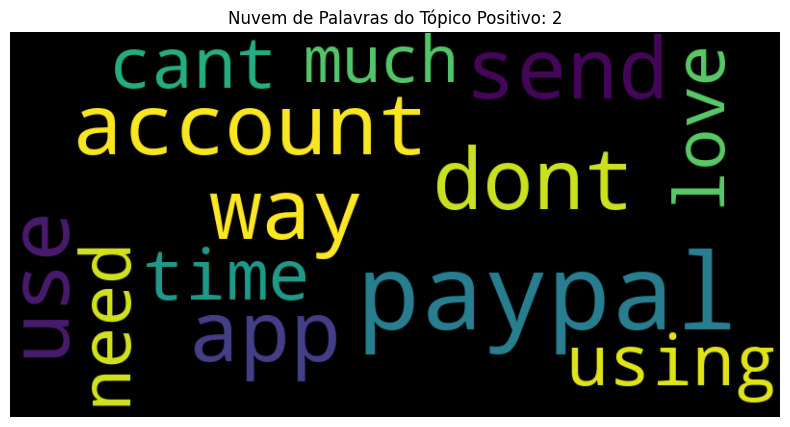

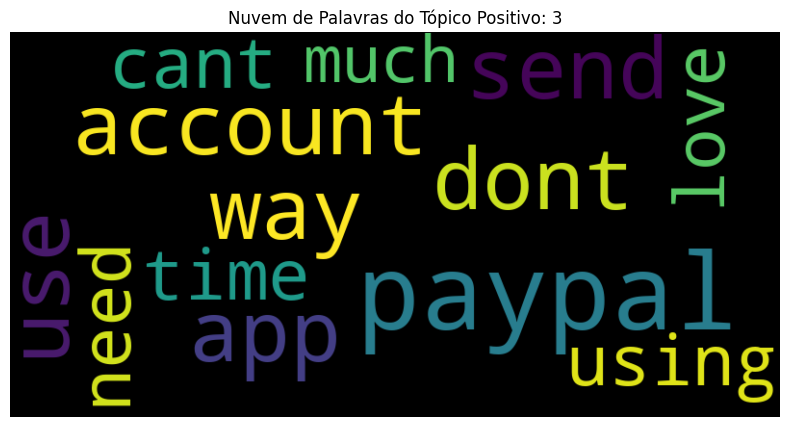

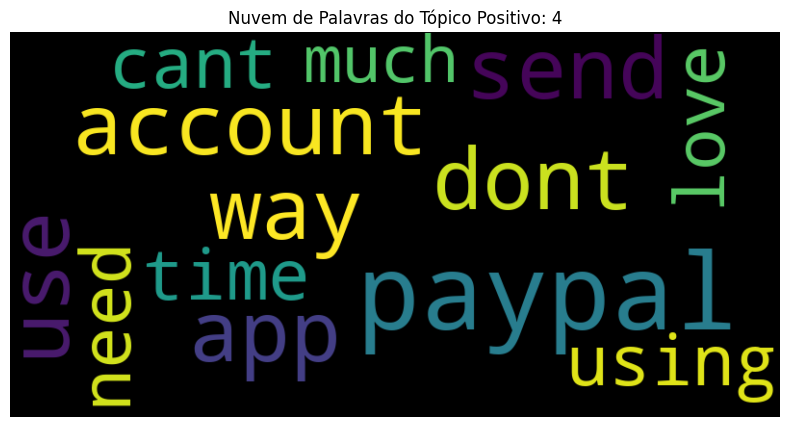

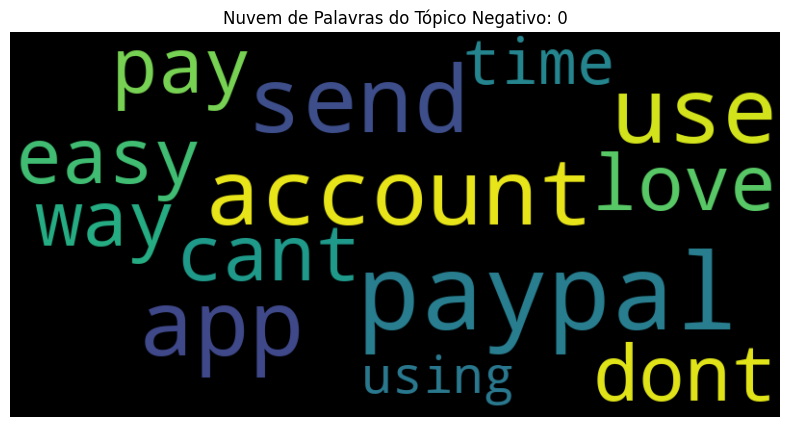

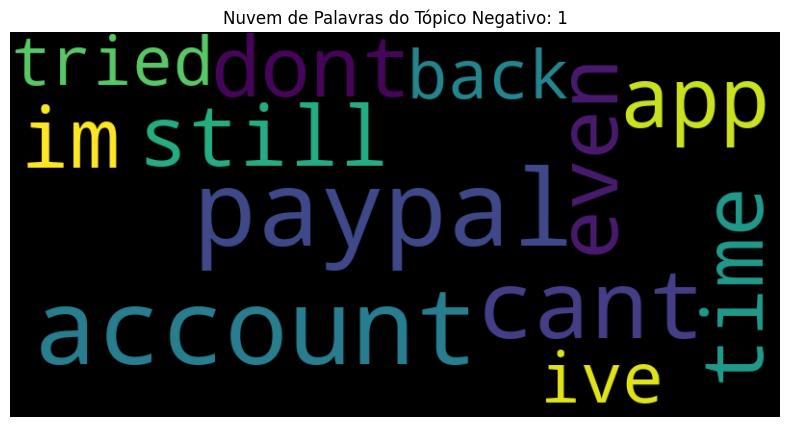

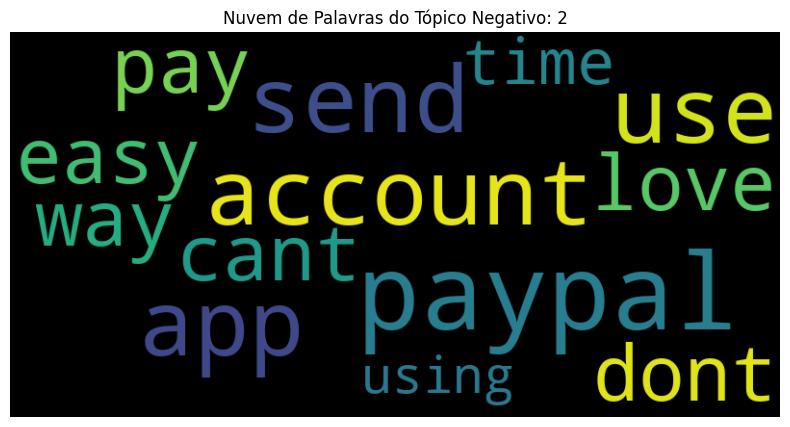

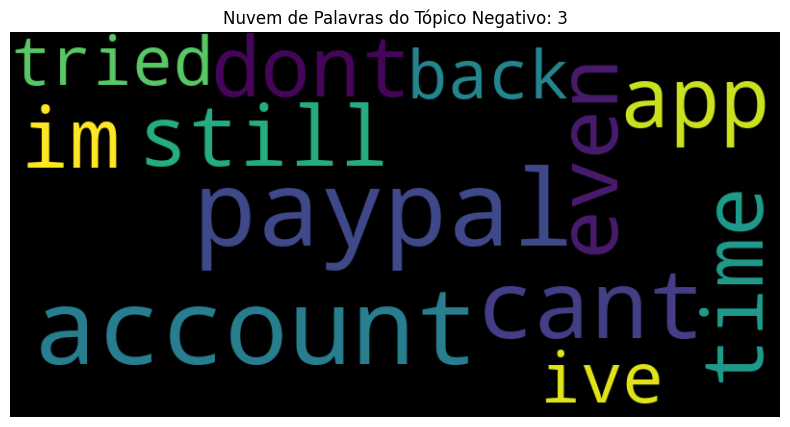

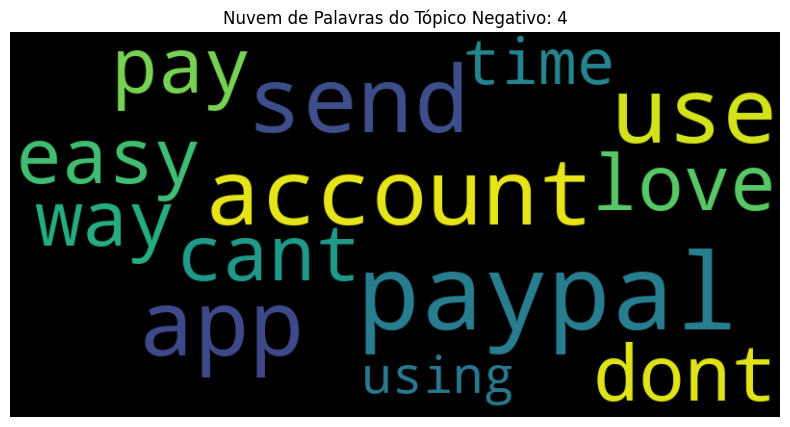

In [55]:
from wordcloud import WordCloud
def criar_nuvem(modelo, topicos_counts, tipo):

  # Para cada um dos top 5 tópicos, criar uma nuvem de palavras
  for topic in range(5):
      words = modelo.get_topic(topicos_counts[topic])

      # Preparar os dados para a nuvem de palavras
      # As palavras serão repetidas de acordo com a probabilidade associada a elas
      cloud_words = ""
      for word, prob in words:
          # Repetir a palavra de acordo com sua probabilidade
          repetition = int(prob * 100)  # ajuste o fator de escala conforme necessário
          cloud_words += (word + " ") * repetition

      # Criar a nuvem de palavras
      wordcloud = WordCloud(width=800, height=400, random_state=21, max_font_size=110).generate(cloud_words)

      # Plotar a nuvem de palavras
      plt.figure(figsize=(10, 5))
      plt.imshow(wordcloud, interpolation="bilinear")
      plt.axis('off')
      plt.title(f"Nuvem de Palavras do Tópico {tipo}: {topic}")
      plt.show()

criar_nuvem(modelo_positivo, positive_topic_counts, 'Positivo')
criar_nuvem(modelo_negativo, negative_topic_counts, 'Negativo')

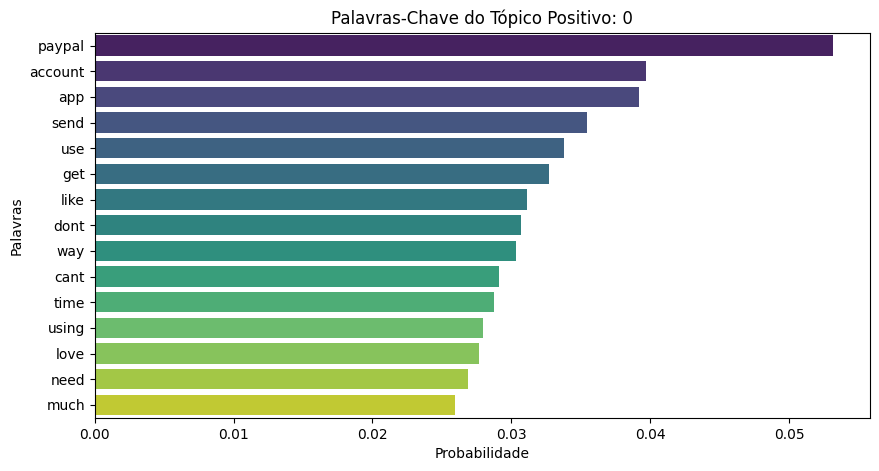

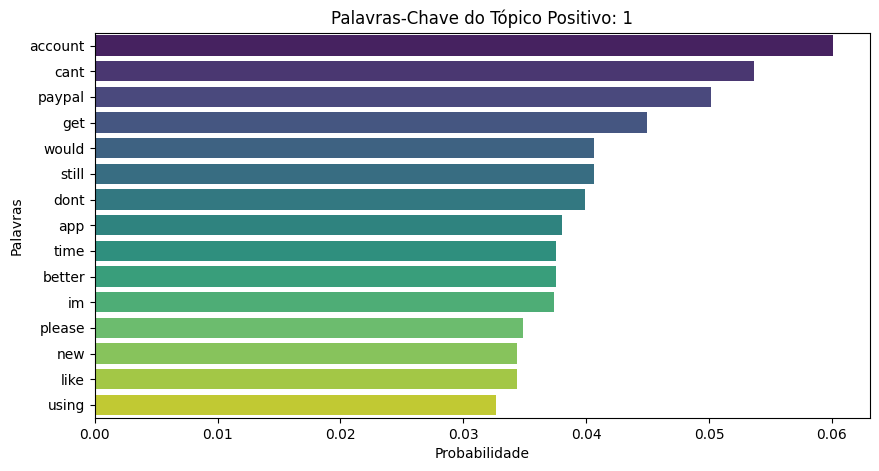

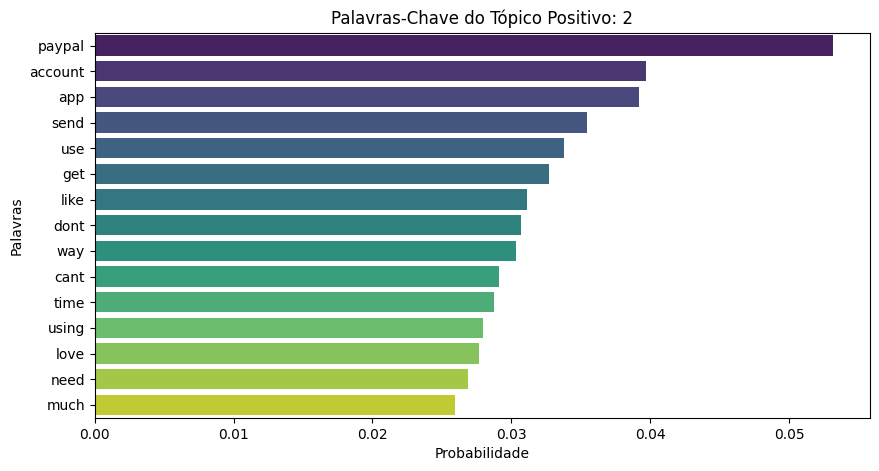

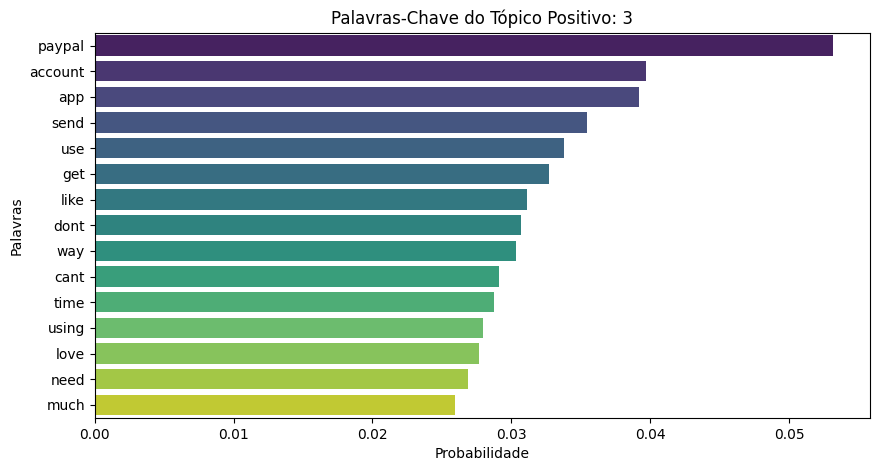

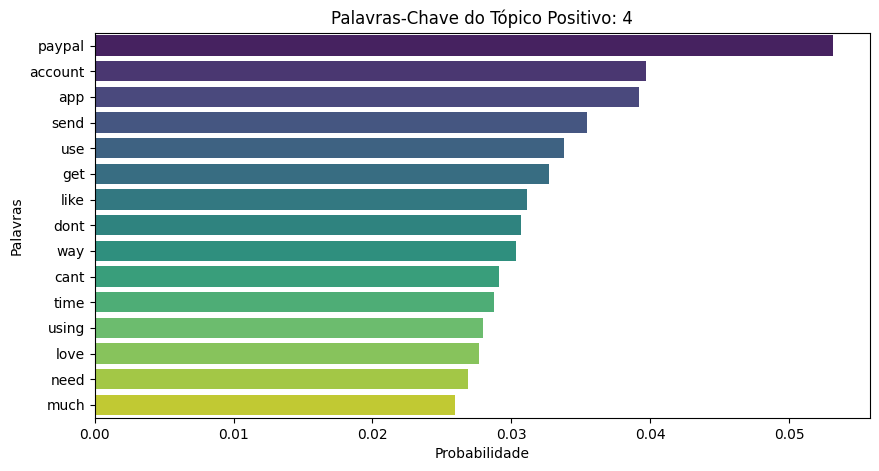

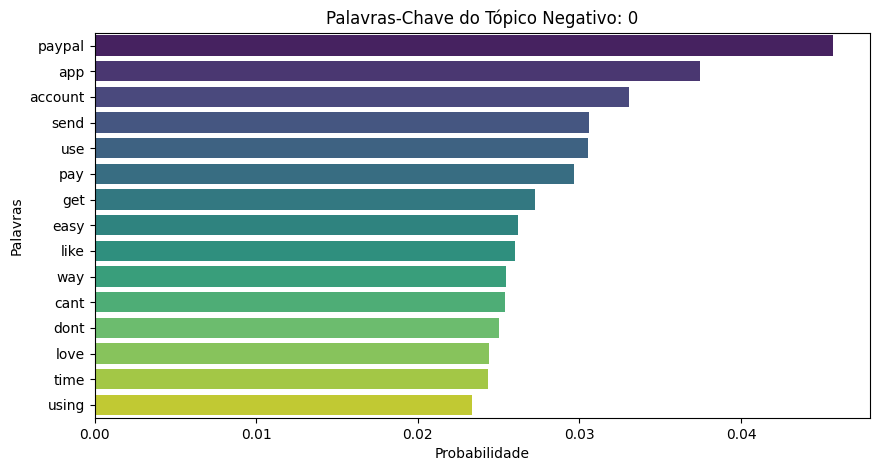

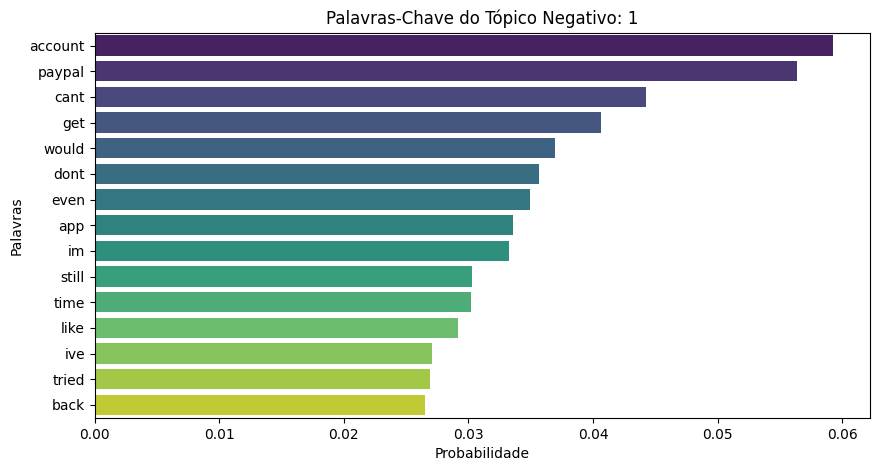

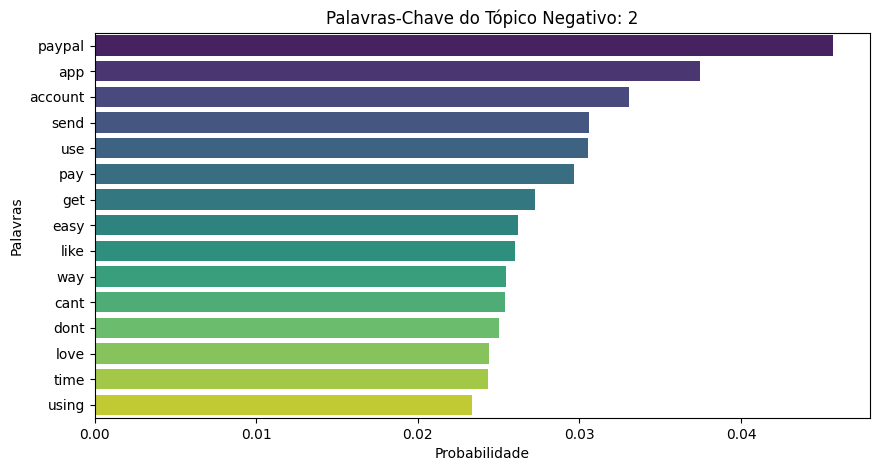

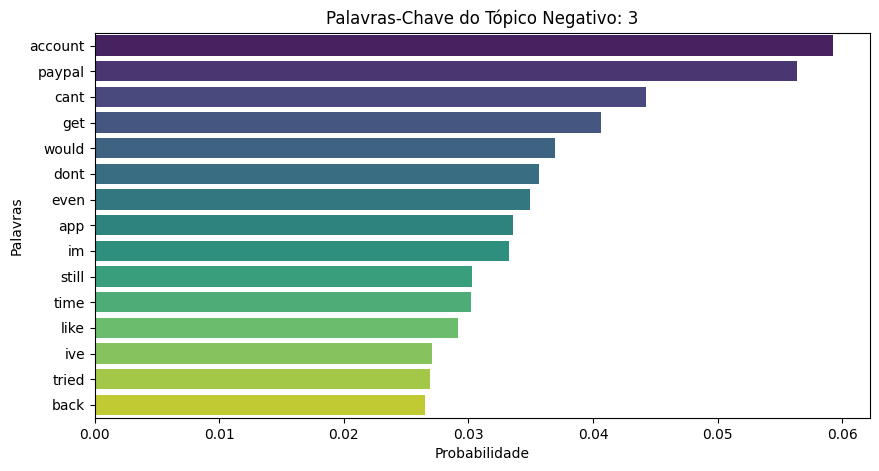

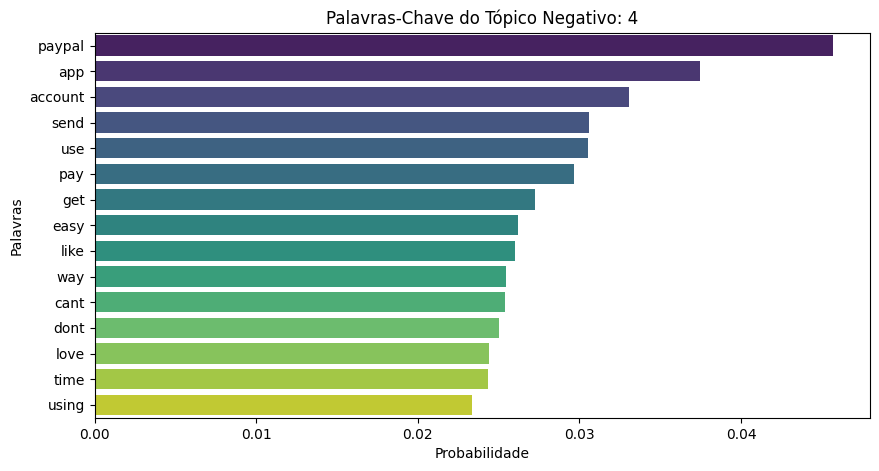

In [57]:
def criar_grafico_de_topicos(modelo, topicos_counts, tipo):
  # Para cada um dos top 5 tópicos, criar um gráfico de barras horizontal com as palavras-chave
  for topic in range(5):
      words = modelo.get_topic(topicos_counts[topic])

      # Separar palavras e probabilidades em duas listas
      word_list = [word for word, prob in words]
      prob_list = [prob for word, prob in words]

      # Criar o gráfico
      plt.figure(figsize=(10, 5))
      sns.barplot(x=prob_list, y=word_list, palette='viridis')
      plt.title(f"Palavras-Chave do Tópico {tipo}: {topic}")
      plt.xlabel("Probabilidade")
      plt.ylabel("Palavras")
      plt.show()
criar_grafico_de_topicos(modelo_positivo, positive_topic_counts, 'Positivo')
criar_grafico_de_topicos(modelo_negativo, negative_topic_counts, 'Negativo')

# Fontes
### https://www.kaggle.com/code/alexahdp/google-play-store-apps-reviews-sentiment-analyze